In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os 
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
KAGGLE_PATH = "/Users/taa/Documents/kaggle/"

In [ ]:
RAW_META_DATA_PATH = os.path.join(KAGGLE_PATH, "data", "birdclef-2025")
DATA_PATH = os.path.join(KAGGLE_PATH, "kaggle_birdclef25", "data", "interim")
exisiting_files = os.listdir(DATA_PATH)
print("Number of label", len(exisiting_files))

Number of label 94


In [4]:
raw_meta_df = pd.read_csv(os.path.join(RAW_META_DATA_PATH, "train.csv"))
processed_meta_df = pd.read_csv(os.path.join(DATA_PATH, "train_filtered.csv"))

In [5]:
raw_meta_df.shape, raw_meta_df["primary_label"].unique().size

((28564, 13), 206)

In [6]:
processed_meta_df.shape, processed_meta_df["primary_label"].unique().size

((27128, 14), 206)

In [7]:
processed_meta_df.head()

,Unnamed: 0,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


# Data Loader

In [8]:
from torch.utils.data import Dataset, DataLoader
import glob

In [9]:
SPECTROGRAM_STYLE = "mel"

In [10]:
class BirdclefDataset(Dataset):
    def __init__(self, meta_df: pd.DataFrame, data_path: str, spectrogram_style: str):
        self.spectrogram_style = spectrogram_style
        self.data_path = data_path
        
        self.samples = []
        for _, row in meta_df.iterrows():
            primary_label = row["primary_label"]
            filename = os.path.splitext(os.path.basename(row["filename"]))[0]
            
            pattern = os.path.join(data_path, primary_label, f"{filename}_clip*.ogg")
            clip_paths = glob.glob(pattern)
            
            for clip_path in clip_paths:
                self.samples.append({
                    "clip_path": clip_path,
                    "label": primary_label
                })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        clip_path = sample["clip_path"]
        label = sample["label"]

        audio, sr = librosa.load(clip_path, sr=None)
        
        if self.spectrogram_style == "mel":
            audio = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
            audio = librosa.power_to_db(audio, ref=np.max)
        elif self.spectrogram_style == "stft":
            audio = librosa.stft(audio, n_fft=2048, hop_length=512)
            audio = np.abs(audio)
            audio = librosa.amplitude_to_db(audio, ref=np.max)
        
        return audio, label

In [11]:
train_ds = BirdclefDataset(
    meta_df=processed_meta_df,
    data_path=DATA_PATH,
    spectrogram_style=SPECTROGRAM_STYLE
)

In [12]:
len(train_ds)

79787

In [13]:
sample, label = next(iter(train_ds))

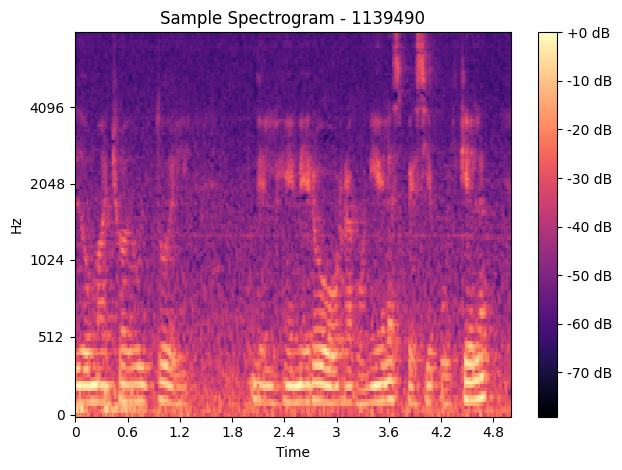

In [14]:
if SPECTROGRAM_STYLE == "mel":
    librosa.display.specshow(sample, sr=32000, x_axis='time', y_axis='mel', fmax=8000)
elif SPECTROGRAM_STYLE == "stft":
    librosa.display.specshow(sample, sr=32000, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Sample Spectrogram - {label}")
plt.tight_layout()
plt.show()

In [15]:
sample.shape

(128, 313)